# Working with XDF data using MNE
The goal of this notebook is to import data saved using the LSL Lab Recorder, and run through some pre-processing steps using [MNE-Python](https://mne.tools/stable/index.html)!

In [1]:
import mne
import matplotlib.pyplot as plt
import pyxdf
import numpy as np
import time
import librosa # optional, only needed to convert MIDI keys to notes

## Path to dataset

This experiment involved three participants, where:
- one subject played the piano, while being observed by
- two other subjects (one expert and one novice musician)

Three ~10 minute runs were recorded:
- Run 1: random notes
- Run 2: basic melodies
- Run 3: more advanced pieces

In [2]:
DATA_PATH = r'/Volumes/GoogleDrive/.shortcut-targets-by-id/1mvHxk9Ra9K7MmjQxaRYiZKwUw4Y8o841/AC23/DATA/passive_piano/data/sub-CMP/ses-S001/eeg/'
DATA_PATH+= 'sub-CMP_ses-S001_task-Default_run-001_eeg.xdf'

In [3]:
# Read in the LSL streams from the XDF file
START_TIME = time.time()
streams, header = pyxdf.load_xdf(DATA_PATH) # this could take ~17 seconds..
print(f'Loaded in {time.time() - START_TIME} s')

Loaded in 29.493717908859253 s


The following LSL streams were recorded:
- CGX channel data (x 3)
- CGX impedance data (x 3)
- Glove
- Time-stamps for DVS alignement
- Mic

In [4]:
len(streams)

9

In [5]:
for i, s in enumerate(streams):
    s_name = s['info']['name'][0]
    
    if 'CGX' in s_name:
        host_name = streams[4]['info']['hostname']
        print(i, s_name, host_name)

3 CGX Quick-32r Q32r-0510 Impedance ['ecelab12']
4 CGX Quick-32r Q32r-0510 ['ecelab12']
5 CGX Quick-20r v2 Q20r-0537 ['ecelab12']
6 CGX Quick-20r v2 Q20r-0537 Impedance ['ecelab12']
7 CGX Quick-32r Q32r-0524 Impedance ['ecelab12']
8 CGX Quick-32r Q32r-0524 ['ecelab12']


## Check the duration of each recorded stream

In [6]:
for s in streams:
    name = s['info']['name']
    
    first_timestamp = s['time_stamps'][0]
    last_timestamp = s['time_stamps'][-1]
    print(name, first_timestamp, last_timestamp -first_timestamp)

['ev_ts'] 1061646.239956732 594.1014887294732
['glove_data'] 1061645.539068455 595.020513759926
['MIDIStream'] 1061671.436380126 559.5842775718775
['CGX Quick-32r Q32r-0510 Impedance'] 1061645.51966225 595.160598548362
['CGX Quick-32r Q32r-0510'] 1061645.5196696813 595.178578638006
['CGX Quick-20r v2 Q20r-0537'] 1061645.53323099 595.0447412489448
['CGX Quick-20r v2 Q20r-0537 Impedance'] 1061645.5333178076 595.0485199717805
['CGX Quick-32r Q32r-0524 Impedance'] 1061645.5733182535 595.044801027514
['CGX Quick-32r Q32r-0524'] 1061645.5734055778 595.0445607902948


In [7]:
# Get the last EEG headset to start streaming data, and use that as t=0
last_eeg_start_times = []

for s in streams: # loop through remaining streams
    
    s_name = s['info']['name'][0]
    #print(s_name)
    
    if 'CGX' in s_name:
        t0 = s['time_stamps'][0]
        #print(t0, '\t', s_name)
        last_eeg_start_times.append(t0)
        #print(last_eeg_start_times)
    
t0 = max(last_eeg_start_times) # start when the last EEG stream started (prevents zero padding)
print(t0, '\t', '<== earliest')   

1061645.5734055778 	 <== earliest


# Collect stream info and data

In [8]:
# Identify EEG data and impedance streams separately to collect metadata (channel names, etc)
# Remaining streams are collected in one dict

# Dict to collect headset data by subject
eeg_t = {}
eeg_data = {}
eeg_sfreq = {}
eeg_ch_names = {}
eeg_ch_units = {}
z_t = {}
z_data = {}
z_sfreq = {}
z_ch_names = {}
z_ch_units = {}

lsl_streams = {} # for collecting time stamps and data for all misc. LSL streams

for s in streams:
    s_name = s['info']['name'][0]
    s_type = s['info']['type'][0]
    print(f'Stream Name: {s_name}\tType: {s_type}')
    print('-'*50)
    
    # Get the EEG data stream for CGX
    if ('CGX' in s_name) and (s_type == 'EEG'):
        cgx_name = s_name.split('-')[-1]
        
        # offset by start of last CGX stream
        eeg_time_stamps = s['time_stamps'] - t0
        
        # remove data before t0:
        eeg_t[cgx_name] = eeg_time_stamps[eeg_time_stamps >= 0]
        eeg_data[cgx_name] = s['time_series'][eeg_time_stamps >= 0]
        
        eeg_ch_names[cgx_name] = [ch['label'][0] for ch in s['info']['desc'][0]['channels'][0]['channel']]
        eeg_ch_units[cgx_name] = [ch['unit'][0] for ch in s['info']['desc'][0]['channels'][0]['channel']]
        eeg_sfreq[cgx_name] = s['info']['effective_srate']
        
        print(f'Channels: {eeg_ch_names[cgx_name]}')
        print(f'Unit: {eeg_ch_units[cgx_name]}')
        print(f'Eff. Sampling Rate: {eeg_sfreq[cgx_name]} Hz')
        
    # Get the impedance data stream for CGX
    elif ('CGX' in s_name) and (s_type == 'Impeadance'): # typo in the stream name?
        cgx_name = s_name.split('-')[-1].split(' ')[0]
        
        # offset by start of last CGX stream
        z_time_stamps = s['time_stamps'] - t0
        
        # remove data before t0:
        z_t[cgx_name] = z_time_stamps[z_time_stamps >= 0]
        z_data[cgx_name] = s['time_series'][z_time_stamps >= 0]
        
        z_ch_names[cgx_name] = [ch['label'][0] for ch in s['info']['desc'][0]['channels'][0]['channel']]
        z_ch_units[cgx_name] = [ch['unit'][0] for ch in s['info']['desc'][0]['channels'][0]['channel']]
        z_sfreq[cgx_name] = s['info']['effective_srate']
        print(f'Channels: {z_ch_names[cgx_name]}')
        print(f'Unit: {z_ch_units[cgx_name]}')
        print(f'Eff. Sampling Rate: {z_sfreq[cgx_name]} Hz')
        
    # Misc streams
    else:
        lsl_streams[s_type] = {}
        
        # offset by start of last CGX stream
        lsl_time_stamps = s['time_stamps'] - t0
        
        # remove data before t0
        lsl_streams[s_type]['time'] = lsl_time_stamps[lsl_time_stamps >= 0]
        lsl_streams[s_type]['data'] = s['time_series'][lsl_time_stamps >= 0]
        
        if 'effective_srate' in s['info'].keys():
            lsl_sfreq = s['info']['effective_srate']
            lsl_streams[s_type]['effective_srate'] = lsl_sfreq
            print(f'Eff. Sampling Rate: {lsl_sfreq} Hz')
            
        print('shape:', lsl_streams[s_type]['data'].shape)
        
    print('='*50)

Stream Name: ev_ts	Type: timestamp
--------------------------------------------------
Eff. Sampling Rate: 0.9998294597956898 Hz
shape: (595, 1)
Stream Name: glove_data	Type: imu_data
--------------------------------------------------
Eff. Sampling Rate: 99.9931913138909 Hz
shape: (59495, 6)
Stream Name: MIDIStream	Type: MIDI
--------------------------------------------------
Eff. Sampling Rate: 0 Hz
shape: (1034, 6)
Stream Name: CGX Quick-32r Q32r-0510 Impedance	Type: Impeadance
--------------------------------------------------
Channels: ['AF7-Z', 'Fpz-Z', 'F7-Z', 'Fz-Z', 'T7-Z', 'FC6-Z', 'Fp1-Z', 'F4-Z', 'C4-Z', 'Oz-Z', 'CP6-Z', 'Cz-Z', 'PO8-Z', 'CP5-Z', 'O2-Z', 'O1-Z', 'P3-Z', 'P4-Z', 'P7-Z', 'P8-Z', 'Pz-Z', 'PO7-Z', 'T8-Z', 'C3-Z', 'Fp2-Z', 'F3-Z', 'F8-Z', 'FC5-Z', 'AF8-Z', 'A2-Z', 'ExG 1-Z', 'ExG 2-Z', 'ACC32-Z', 'ACC33-Z', 'ACC34-Z', 'Packet Counter-Z', 'TRIGGER-Z']
Unit: ['kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 

In [9]:
print(sum(eeg_data['0524'][:, -1]>0)) # number of events in trigger channel (mic)
np.unique(eeg_data['0524'][:, -1]) # types of trigger events seen

58321


array([    0.,  8192., 16384., 24576.], dtype=float32)

Event | Description
:-- | --:
Audio Left | 8192
Audio Right | 16384
Audio Left+Right | 24576

(is the mic outputting stereo?)

# Visualize EEG data for entire run

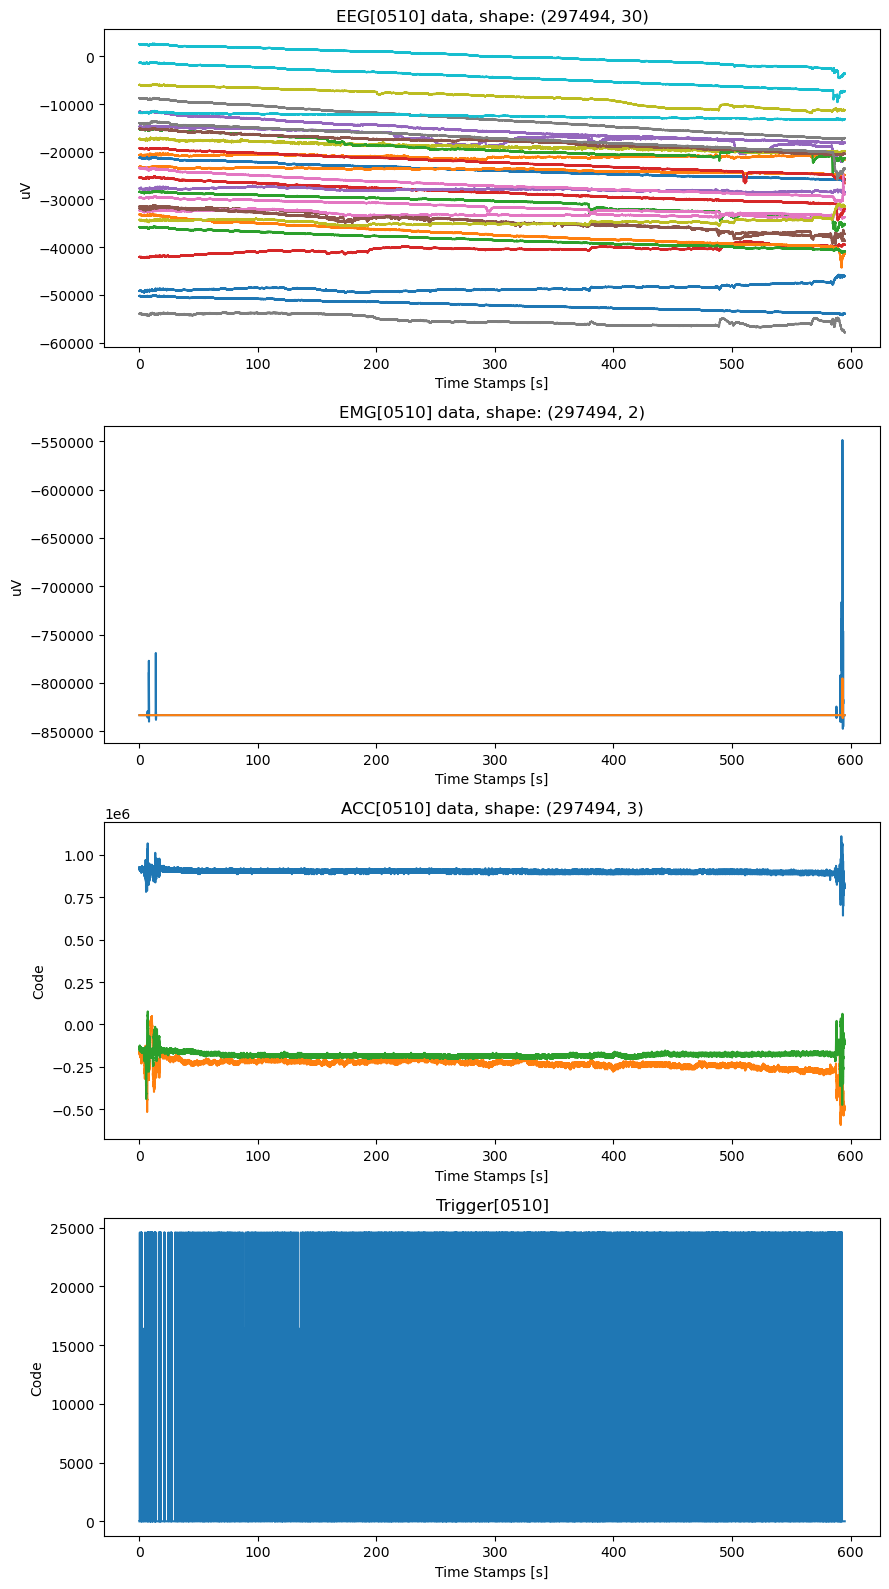

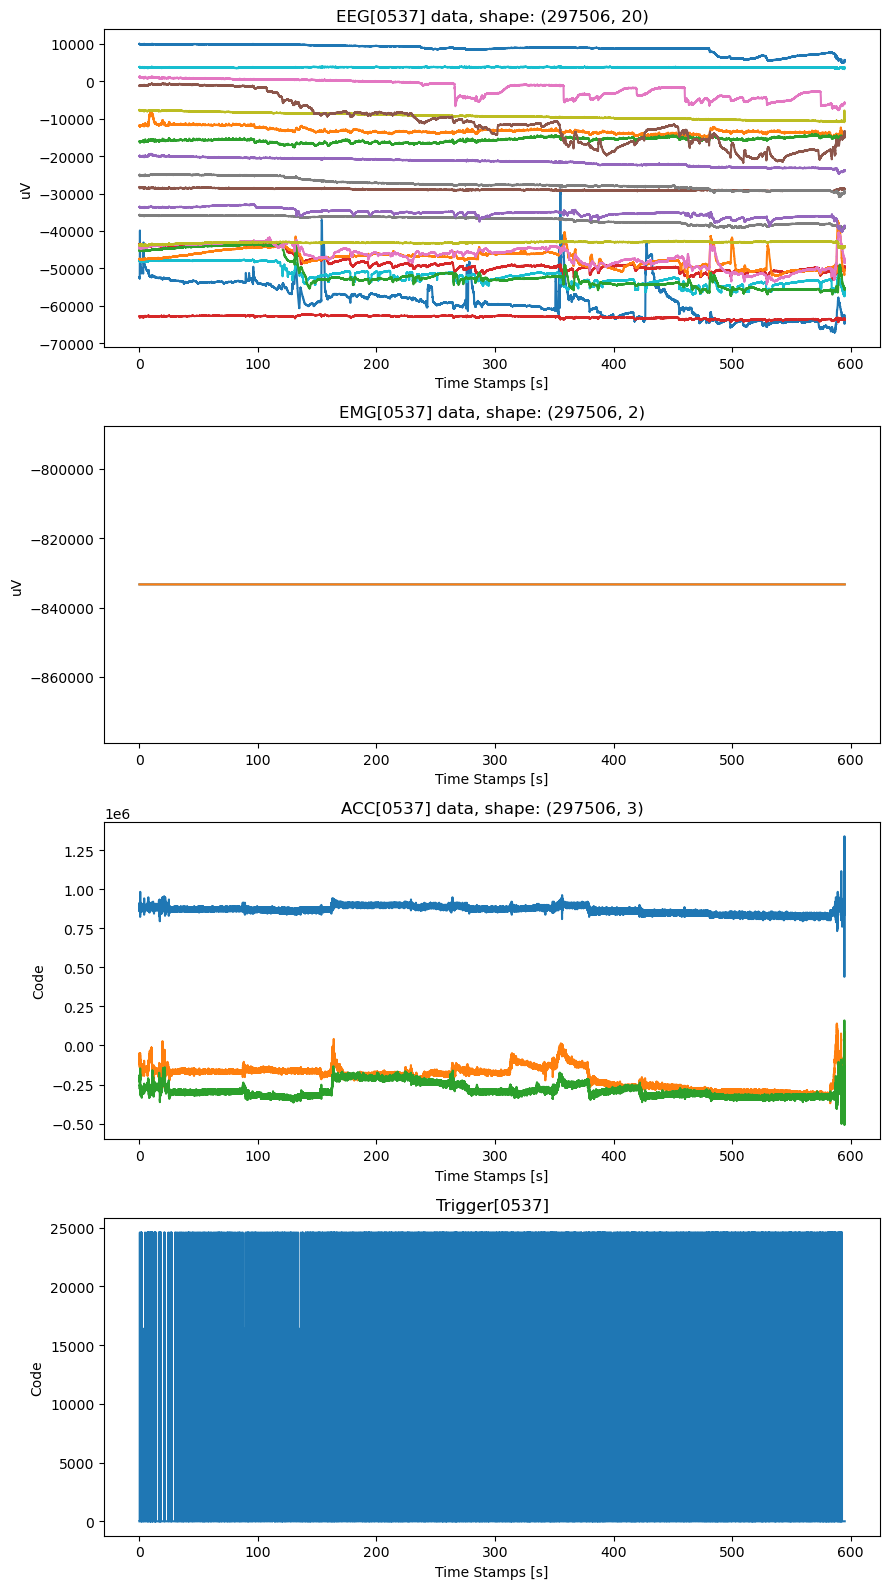

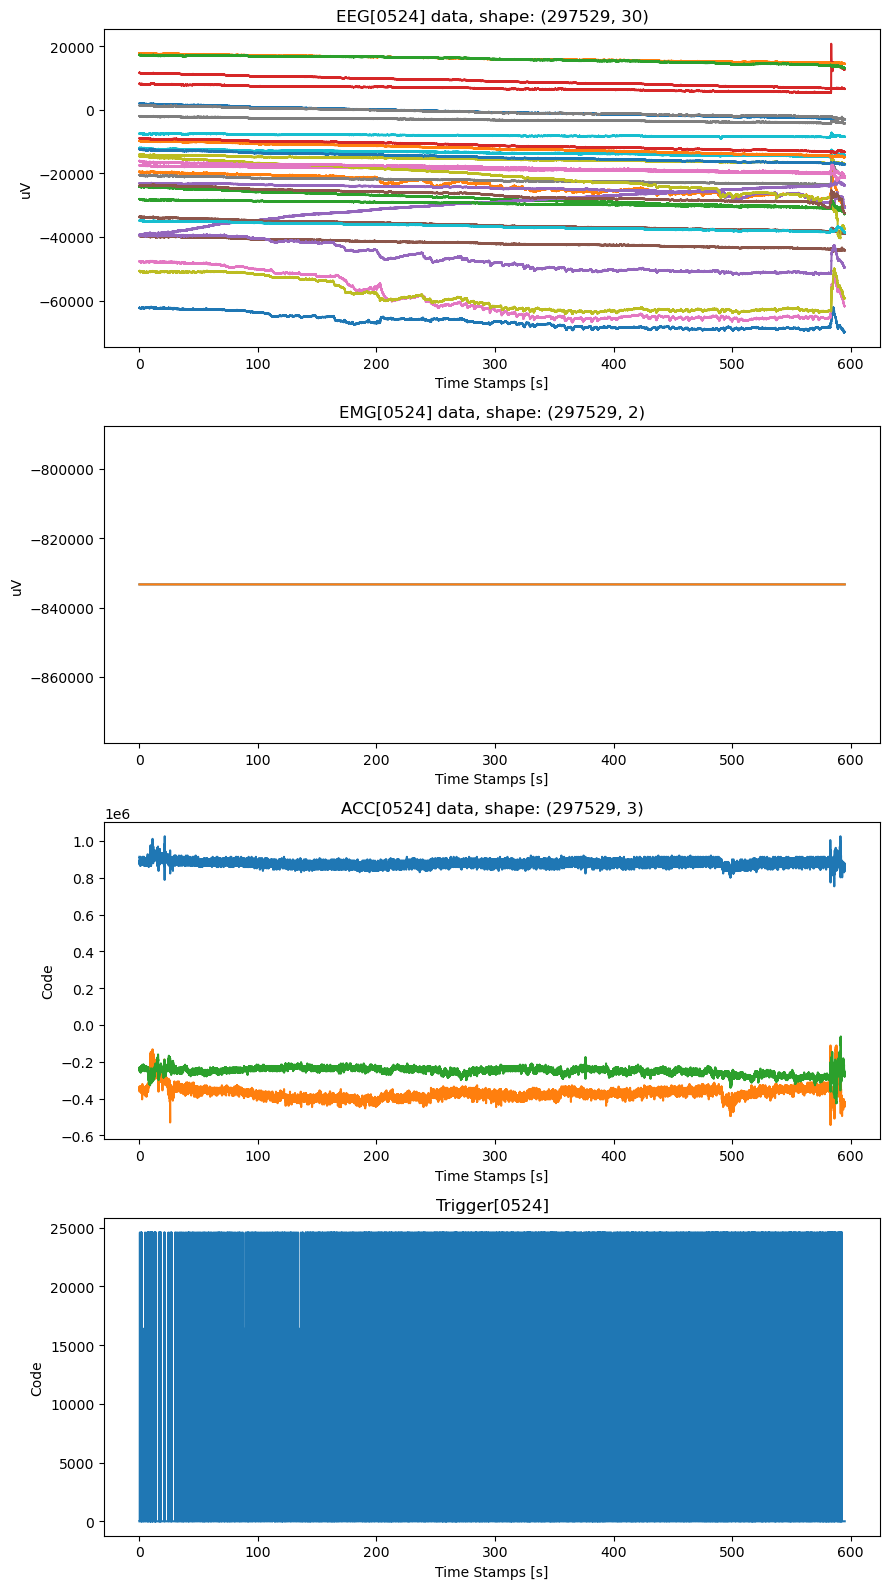

In [10]:
for cgx_name in eeg_data:
    
    # Plot EEG data
    fig, ax = plt.subplots(4, 1, figsize=(9, 16))

    i = 0
    ax[i].plot(eeg_t[cgx_name], eeg_data[cgx_name][:, :-7])
    ax[i].set_ylabel('uV')
    ax[i].set_xlabel('Time Stamps [s]')
    ax[i].set_title(f'EEG[{cgx_name}] data, shape: {eeg_data[cgx_name][:, :-7].shape}')

    i += 1
    ax[i].plot(eeg_t[cgx_name], eeg_data[cgx_name][:, -7:-5])
    ax[i].set_ylabel('uV')
    ax[i].set_xlabel('Time Stamps [s]')
    ax[i].set_title(f'EMG[{cgx_name}] data, shape: {eeg_data[cgx_name][:, -7:-5].shape}')

    i += 1
    ax[i].plot(eeg_t[cgx_name], eeg_data[cgx_name][:, -5:-2])
    ax[i].set_ylabel('Code')
    ax[i].set_xlabel('Time Stamps [s]')
    ax[i].set_title(f'ACC[{cgx_name}] data, shape: {eeg_data[cgx_name][:, -5:-2].shape}')

    # skip packet counter plot

    i += 1
    ax[i].plot(eeg_t[cgx_name], eeg_data[cgx_name][:, -1])
    ax[i].set_ylabel('Code')
    ax[i].set_xlabel('Time Stamps [s]')
    ax[i].set_title(f'Trigger[{cgx_name}]')

    '''
    # Plot event markers
    for i in range(len(events)):
        event_t = events_t[i]
        event_v = events[i][0]
        event_type = events[i][1]

        if event_type == 'left':
            ax[0].axvline(x = event_t, c='pink')
        elif event_type == 'right':
            ax[0].axvline(x = event_t, c='c')
        elif event_type == 'enter':
            ax[0].axvline(x = event_t, c='r')

    ax[1].plot(z_t, z_data)
    ax[1].set_ylabel('kOhms')
    ax[1].set_title('Impedance')

    '''

    plt.tight_layout()
    plt.show()

# Prepare to import data to mne

In [11]:
eeg_sfreq

{'0510': 499.88358269483683,
 '0537': 500.00609931158095,
 '0524': 500.00961202901084}

In [12]:
# Are the starting samples time-aligned now?
print('\t'.join(['CGX', 'Start Time [ms]', 'Duration [ms]', 'Shape']))
for cgx_name in eeg_t:
    print(
        '{}\t{:.6f}\t{:.6f}\t{}'.format(
            cgx_name,
            eeg_t[cgx_name][0]*1e3, # * eeg_sfreq[cgx_name], 
            eeg_t[cgx_name][-1]*1e3, # * eeg_sfreq[cgx_name], 
            eeg_data[cgx_name].shape,
         )
    )
    print(
        '{}\t{:.6f}\t{:.6f}\t{}'.format(
            cgx_name,
            z_t[cgx_name][0]*1e3, # * z_sfreq[cgx_name],
            z_t[cgx_name][-1]*1e3, # * z_sfreq[cgx_name],
            z_data[cgx_name].shape,
         )
    )
    
# Looks like we might still be off by one sample...

CGX	Start Time [ms]	Duration [ms]	Shape
0510	0.276680	595124.842742	(297494, 37)
0510	0.269250	595106.855221	(297485, 37)
0537	1.824900	595004.566661	(297506, 27)
0537	1.911702	595008.432202	(297508, 27)
0524	0.000000	595044.560790	(297529, 37)
0524	1.912638	595044.713703	(297528, 37)


## Rescale EEG data to V
(only run this once!)

In [13]:
for cgx_name in eeg_data:
    print(eeg_data[cgx_name][:, 0])

    # Rescale units of eeg_data to V
    if 'microvolts' in eeg_ch_units[cgx_name]:
        eeg_data[cgx_name][:, :-5] /= 1e6 # only rescale EEG and ExG channels

    print(eeg_data[cgx_name][:, 0])

[-49160.062 -49158.19  -49162.04  ... -46098.89  -46105.406 -46108.8  ]
[-0.04916006 -0.04915819 -0.04916204 ... -0.04609889 -0.04610541
 -0.0461088 ]
[-52282.387 -52275.492 -52271.68  ... -64283.7   -64296.08  -64297.363]
[-0.05228239 -0.05227549 -0.05227168 ... -0.0642837  -0.06429608
 -0.06429736]
[-62275.758 -62278.94  -62272.9   ... -69844.766 -69829.32  -69815.25 ]
[-0.06227576 -0.06227894 -0.0622729  ... -0.06984477 -0.06982932
 -0.06981525]


(Manually) Identify each channel's type for importing data to mne:

In [14]:
ch_types = {}

for cgx_name in eeg_data:
    
    ch_types[cgx_name] = []
    # Use index of A2 to determine how many eeg channels we have (changes between Quick20 and Quick32)
    nchans = eeg_ch_names[cgx_name].index('A2') + 1 # include A2 in eeg channels
    
    ch_types[cgx_name].extend(['eeg']*nchans) # all channels upto and including A2
    ch_types[cgx_name].extend(['misc']*(2+3+1)) # ExG x2, ACC x3, Packet Counter)
    ch_types[cgx_name].extend(['stim']) # Trigger channel (probably unused)

# Import data as an array of raw objects
Each participant get its own raw object

Creating RawArray with float64 data, n_channels=37, n_times=297494
    Range : 0 ... 297493 =      0.000 ...   595.125 secs
Ready.


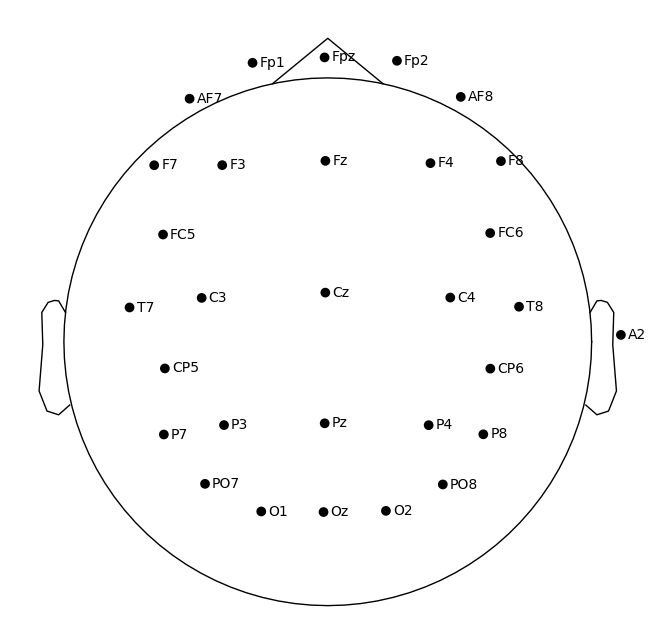

Creating RawArray with float64 data, n_channels=27, n_times=297506
    Range : 0 ... 297505 =      0.000 ...   595.003 secs
Ready.


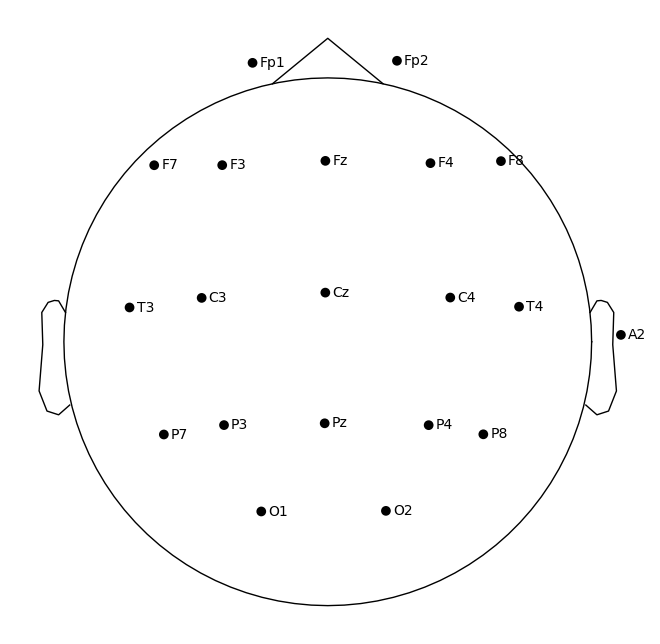

Creating RawArray with float64 data, n_channels=37, n_times=297529
    Range : 0 ... 297528 =      0.000 ...   595.045 secs
Ready.


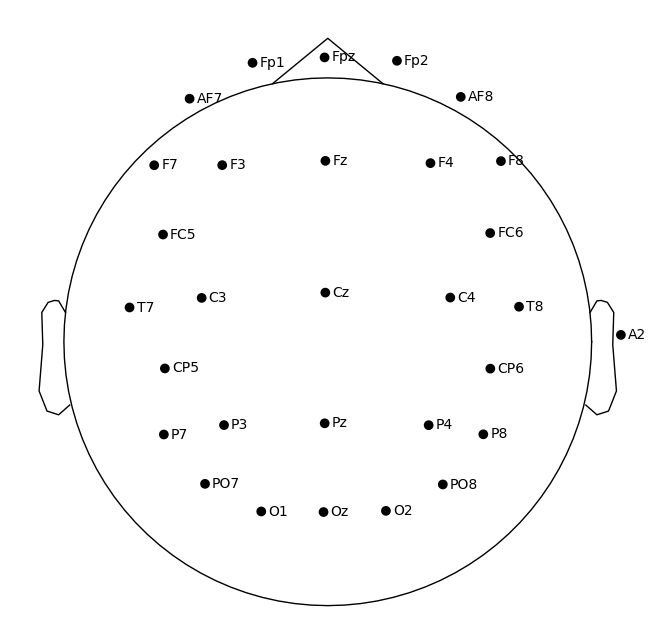

In [15]:
raws = [] # hold raw data for all subjects

for cgx_name in eeg_data:
    
    # Make an info object for importing data to mne:
    # https://mne.tools/stable/generated/mne.create_info.html
    info = mne.create_info(
        ch_names = eeg_ch_names[cgx_name],
        sfreq = eeg_sfreq[cgx_name],
        ch_types = ch_types[cgx_name],
    )
    
    # Import the data as a raw array:
    # https://mne.tools/stable/generated/mne.io.RawArray.html
    raw = mne.io.RawArray(
        data = eeg_data[cgx_name].T, # mne expects (n_channels, n_times)
        info = info,
    )
    
    # Apply the 10-20 channel montage
    raw.info.set_montage('standard_1020', match_case=False)
    
    # Plot the montage
    mne.viz.plot_montage(raw.info.get_montage())
    
    raws.append(raw)

In [16]:
raws

[<RawArray | 37 x 297494 (595.1 s), ~84.0 MB, data loaded>,
 <RawArray | 27 x 297506 (595.0 s), ~61.3 MB, data loaded>,
 <RawArray | 37 x 297529 (595.0 s), ~84.0 MB, data loaded>]

# Add annotations from MIDI stream

In [17]:
lsl_streams['MIDI']

{'time': array([ 25.86297455,  25.896415  ,  25.89644706, ..., 584.74084771,
        584.79941744, 585.44725212]),
 'data': array([[  0,   1,  72,  72,  97,  97],
        [  0,   1,  60,  60,  93,  93],
        [  0,   1,  55,  55, 100, 100],
        ...,
        [  0,   1,  53,  53,  82,  82],
        [  0,   0,  55,  55,  64,  64],
        [  0,   0,  53,  53,  64,  64]], dtype=int32),
 'effective_srate': 0}

In [18]:
# All "ON" events
lsl_streams['MIDI']['data'][lsl_streams['MIDI']['data'][:, 1] == 1].shape

(517, 6)

In [19]:
# Total number of ON events that were error events
sum(lsl_streams['MIDI']['data'][lsl_streams['MIDI']['data'][:, 1] == 1][:, 0])

29

## Parse MIDI events

In [21]:
from collections import OrderedDict

midi_q = OrderedDict()
midi_events = []
error_events = []
non_error_events = []

for i, msg in enumerate(lsl_streams['MIDI']['data']):
    
    # Parse the MIDI message
    mapping_error = msg[0]
    on_or_off = msg[1]
    played_note = msg[2]
    heard_note = msg[3]
    fmt_note = f'{played_note}->{heard_note}'
    played_velocity = msg[4]
    heard_velocity = msg[5]
    
    # Also collect durations of played notes
    if (on_or_off == 1) and ~(played_note in midi_q):
        midi_q[played_note] = {} # add the note to the queue
        on_t = lsl_streams['MIDI']['time'][i]
        midi_q[played_note]['onset'] = on_t
        midi_q[played_note]['velocity'] = played_velocity
        midi_q[played_note]['error'] = mapping_error
        
    elif (on_or_off == 0) and (played_note in midi_q): # note was already ON
        on_t = midi_q[played_note]['onset'] # start time from the queue
        mapping_error = midi_q[played_note]['error']

        # Get the current note's off time from MIDI message
        off_t = lsl_streams['MIDI']['time'][i]

        # Calculate the duration of the note
        midi_events.append(
            [
                on_t, 
                off_t - on_t, # duration
                librosa.midi_to_note(int(fmt_note.split('->')[0])) 
                + '->' 
                + librosa.midi_to_note(int(fmt_note.split('->')[1]))
            ]
        )

        # Log separately if its an error:
        # Collect any feedback error event onsets
        if mapping_error:
            error_events.append(
                [
                    on_t, # onset time
                    off_t - on_t, # setting duration as 0 for now
                    'error',
                ]
            )
        else: # not an error
            non_error_events.append(
                [
                    on_t, # onset time
                    off_t - on_t, # setting duration as 0 for now
                    'non_error',
                ]
            )

        midi_q.pop(played_note, None) # remove note from the queue
            
midi_events = np.array(midi_events) # for easier indexing
midi_events.shape

(516, 3)

In [22]:
error_events = np.array(error_events)
error_events.shape

(29, 3)

In [23]:
error_events

array([['43.52349880011752', '1.0335782417096198', 'error'],
       ['44.76564929750748', '1.2795517649501562', 'error'],
       ['88.06334249582142', '1.3295551184564829', 'error'],
       ['89.36568581406027', '1.2630717591382563', 'error'],
       ['132.35761753981933', '1.1776657737791538', 'error'],
       ['133.61443298566155', '1.2783058953937143', 'error'],
       ['205.16393002984114', '1.2858572613913566', 'error'],
       ['233.88200026471168', '1.146898693870753', 'error'],
       ['234.9928992446512', '1.103430532850325', 'error'],
       ['260.8527053752914', '1.0771680301986635', 'error'],
       ['261.89366290858015', '1.0496472481172532', 'error'],
       ['287.9679577096831', '0.8537302906624973', 'error'],
       ['289.0556980271358', '1.095038021914661', 'error'],
       ['310.51478703599423', '1.0884347222745419', 'error'],
       ['311.5463046999648', '1.0629673500079662', 'error'],
       ['339.52464867336676', '1.1124756652861834', 'error'],
       ['340.5689851

In [24]:
non_error_events = np.array(non_error_events)
non_error_events.shape

(487, 3)

In [25]:
# Total notes played
len(midi_events)

516

In [26]:
# Total number of playback errors
len(error_events)

29

## Add MIDI events / errors as annotations to all raws
https://mne.tools/stable/auto_tutorials/raw/30_annotate_raw.html

In [30]:
note_annot = mne.Annotations(
    onset = midi_events[:, 0],
    duration = midi_events[:, 1], # setting durations to 0 to just label event onsets
    description = midi_events[:, 2]
)

error_annot = mne.Annotations(
    onset = error_events[:, 0],
    duration = error_events[:, 1], # setting durations to 0 to just label event onsets
    description = error_events[:, 2]
)

non_error_annot = mne.Annotations(
    onset = non_error_events[:, 0],
    duration = non_error_events[:, 1], # setting durations to 0 to just label event onsets
    description = non_error_events[:, 2]
)

for raw in raws:
    #raw.set_annotations(note_annot + error_annot + non_error_annot)
    raw.set_annotations(non_error_annot + error_annot) # skip the actual notes played to prevent overlapping events

# Time plots
(before filtering)

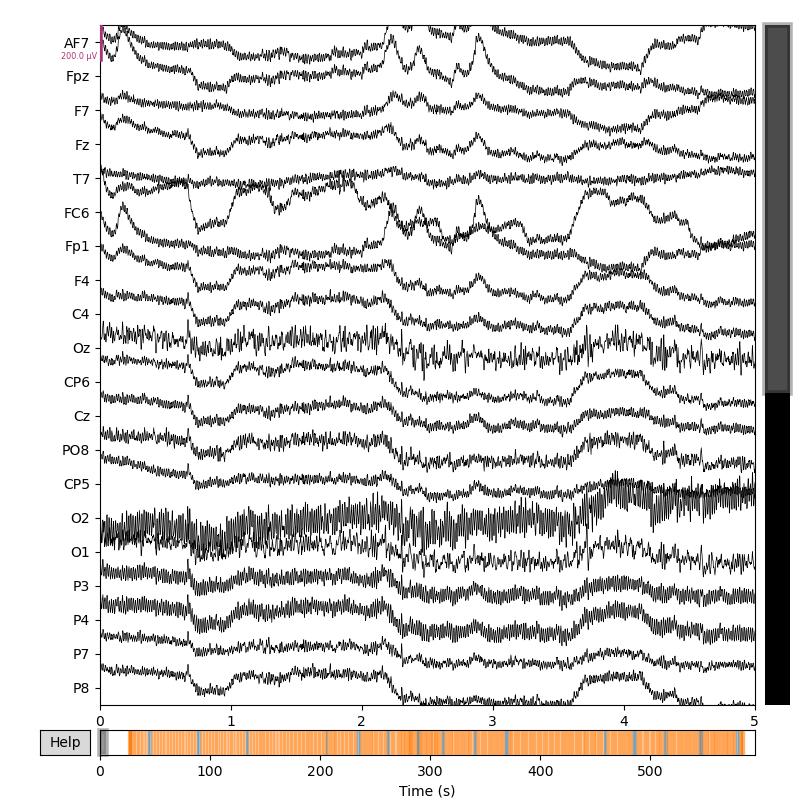

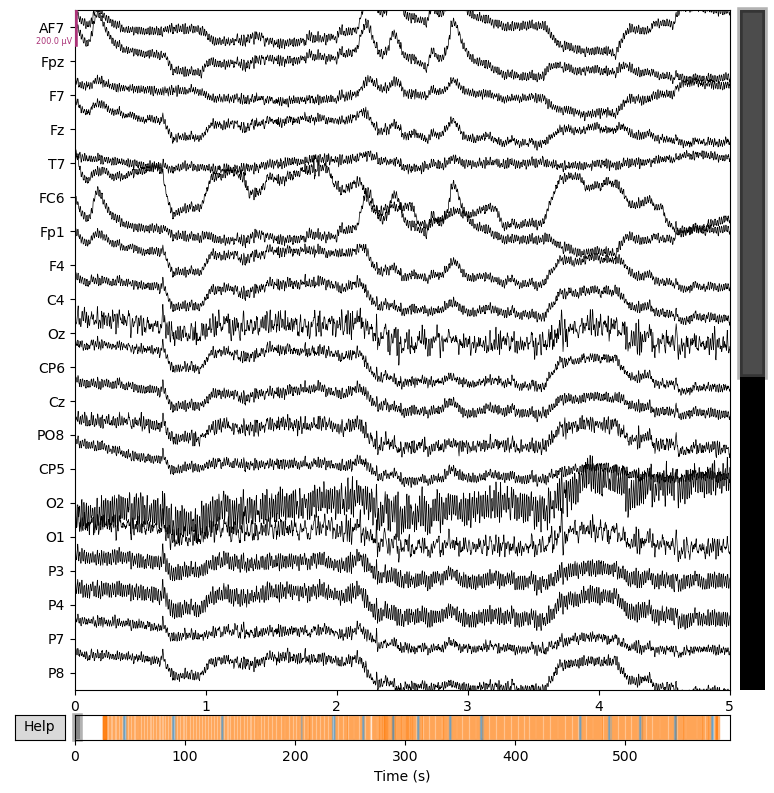

In [31]:
%matplotlib widget

# could go back to 
# %matplotlib inline 
# if the plot doubling becomes annoying

# using widget to make the plot interactive (for scrolling, bad channel selection, etc)

# scaling can help with visibility, especially if we have some bad channels / artifacts
scalings = {
    'eeg': 100e-6, 
    'eog': 500e-6,
    'misc': 100
} 

# In case you want to manually flag some channels as bad (could also click in the plot)
bad_chans = []
raw.info['bads'] = bad_chans

PLOT_WINDOW_START_s = 0
PLOT_WINDOW_DUR_s = 5

# Just plot one subject to visualize annotations
raw.plot(
    scalings = scalings,
    #butterfly = True,
    start = PLOT_WINDOW_START_s,
    duration = PLOT_WINDOW_DUR_s,
)

# Lets find events from annotations

In [32]:
events, event_ids = mne.events_from_annotations(raw)

Used Annotations descriptions: ['error', 'non_error']


In [33]:
events.shape

(516, 3)

In [34]:
# These are event IDs, not event counts!
event_ids

{'error': 1, 'non_error': 2}

In [35]:
# Count number of each event type
eids, counts = np.unique(events[:, 2], return_counts=True)
for i, count in enumerate(counts):
    print(eids[i], count)

1 29
2 487


# Epoching for ERPs

Let's bandpass filter the data:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 1651 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.5s finished


Effective window size : 2.048 (s)


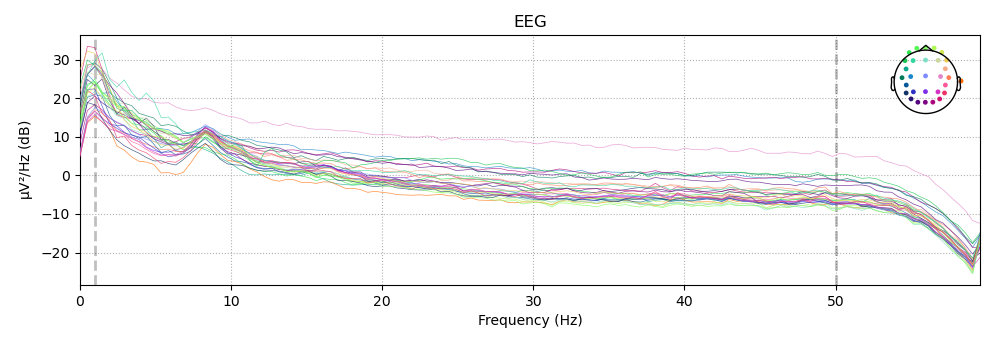

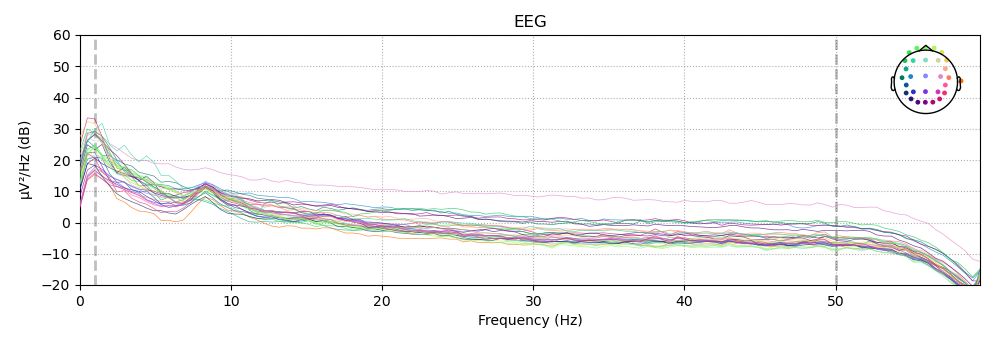

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Effective window size : 2.048 (s)


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.3s finished


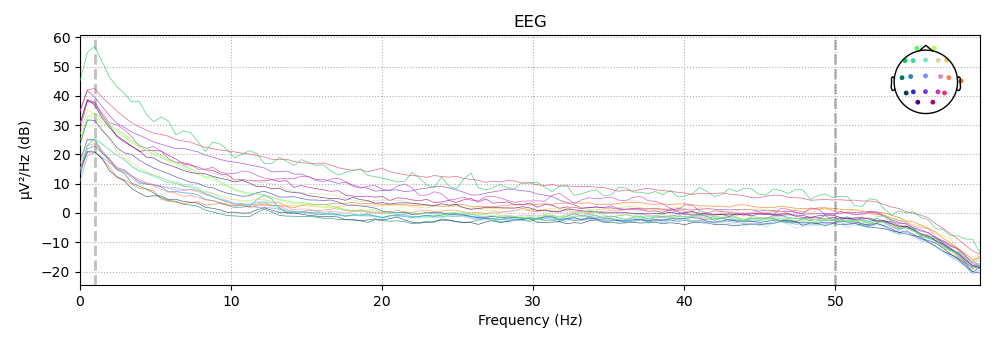

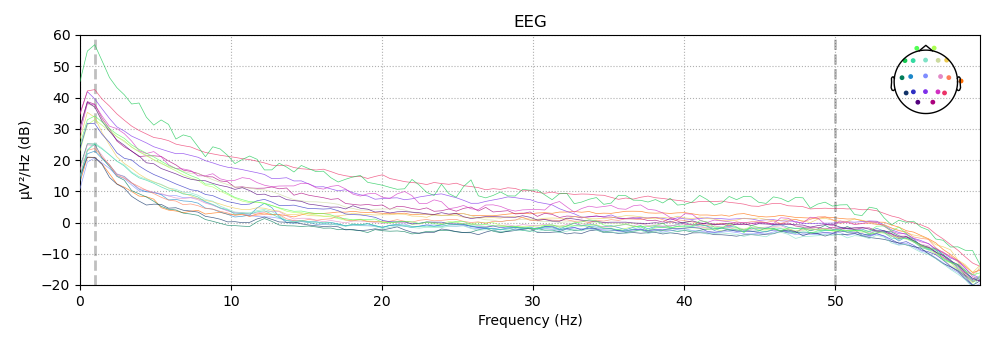

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.5s finished


Effective window size : 2.048 (s)


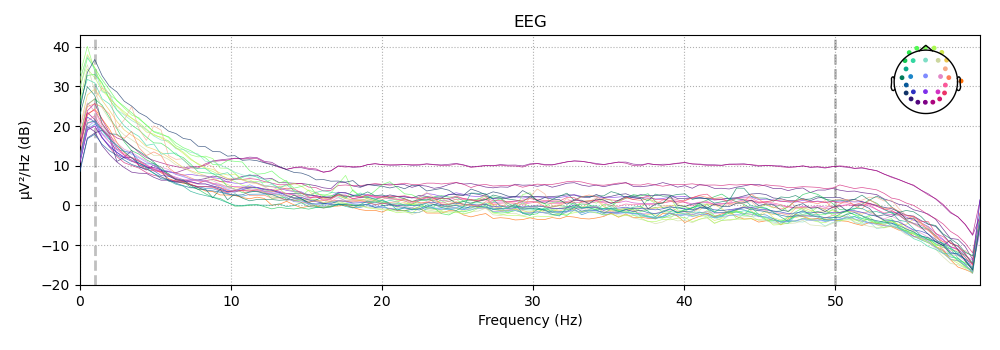

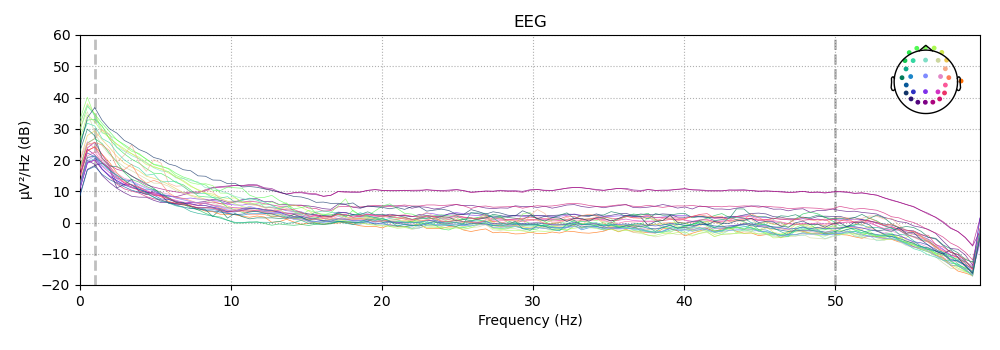

In [37]:
l_freq = 1
h_freq = 50

raws_preproc = []

for raw in raws:
    raw_filt = raw.copy().filter( # make a copy of the array to avoid modifying in place
        l_freq = l_freq, # lower cut-off, in Hz
        h_freq = h_freq, # upper cut-off, in Hz
    )
    
    raws_preproc.append(raw_filt)

    # And look at the PSD again
    n_fft = 1024
    
    fig = raw_filt.compute_psd(
        fmin = 0, # lower limit to plot
        fmax = 60, # upper limit to plot
        n_fft = n_fft
    ).plot(average = False)
    
    # Set the same yaxis scale for all subjects
    fig.get_axes()[0].set_ylim([-20, 60])

    plt.show()

In [41]:
#reject_criteria = {'eeg': 200e-6}

eps = []
for raw_pp in raws_preproc:
    ep = mne.Epochs(
        raw_pp,
        events = events, 
        event_id = event_ids, 
        tmin=-1,
        tmax=1,
        baseline=None,
        event_repeated = 'drop', # drop retains the first event
        preload = True,
        #reject=reject_criteria,
    )
    eps.append(ep)

Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
506 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 506 events and 1001 original time points ...
0 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
506 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 506 events and 1001 original time points ...
0 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
506 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 506 events and 1001 original time points ...
0 bad epochs dropped


# ERPs using all channels

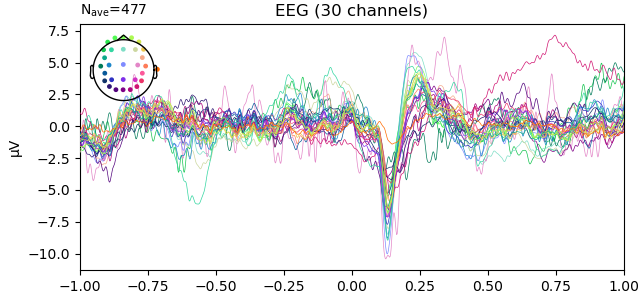

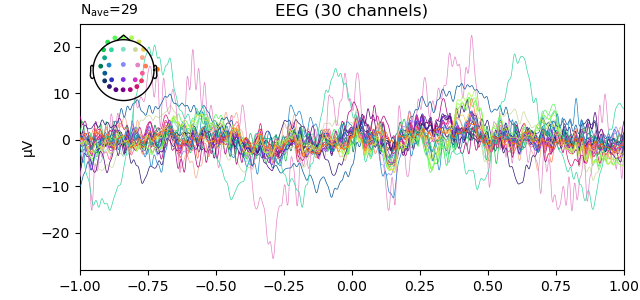

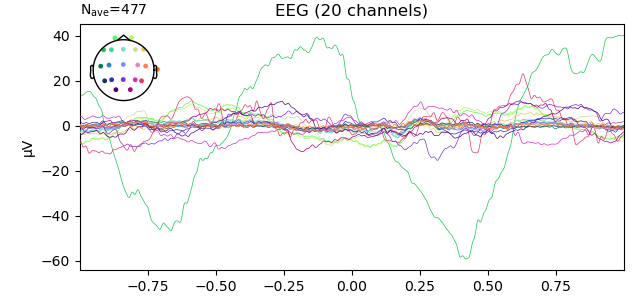

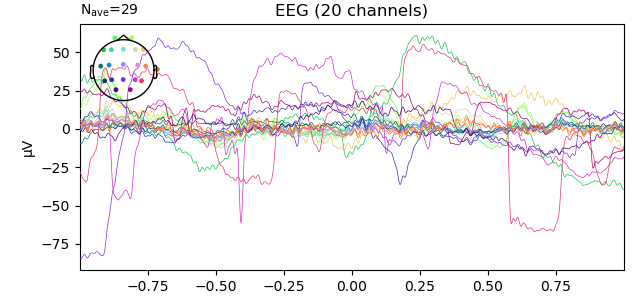

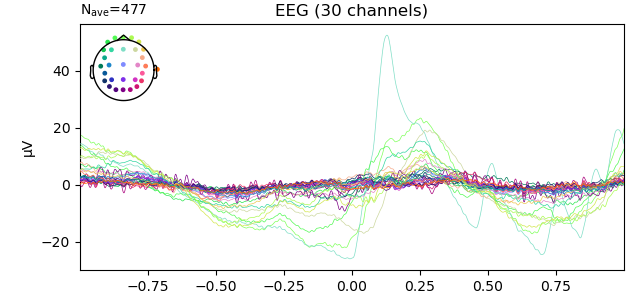

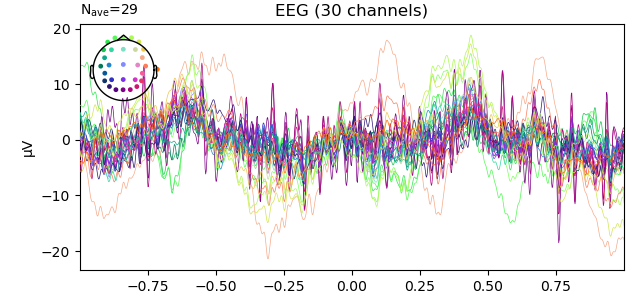

In [42]:
%matplotlib widget 

for ep in eps:
    print("="*100)
    
    fig = ep['non_error'].average(picks=['eeg']).plot()
    fig.get_axes()[0].set_title("No Error")
    
    
    fig = ep['error'].average(picks=['eeg']).plot()
    fig.get_axes()[0].set_title("Error")
    

# Compare ERPs for error and non_error conditions
Only use a subset of channels.

combining channels using "mean"
combining channels using "mean"


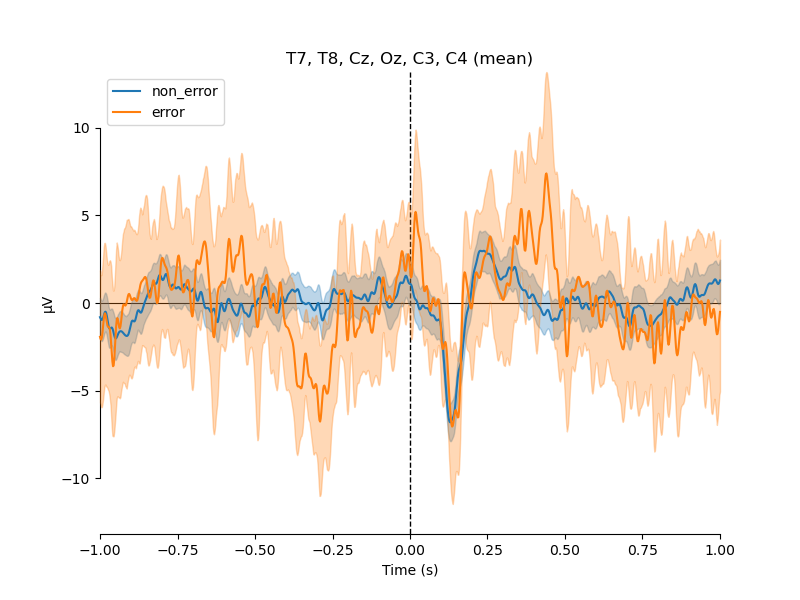

combining channels using "mean"


/var/folders/st/wjnxghxn7_b382gv3l4lxt0m0000gn/T/ipykernel_11419/833227672.py:11: RuntimeWarning: Channel(s) ['T7', 'T8', 'Oz'] could not be picked, because they are not present in the info instance.
  fig = mne.viz.plot_compare_evokeds(


combining channels using "mean"


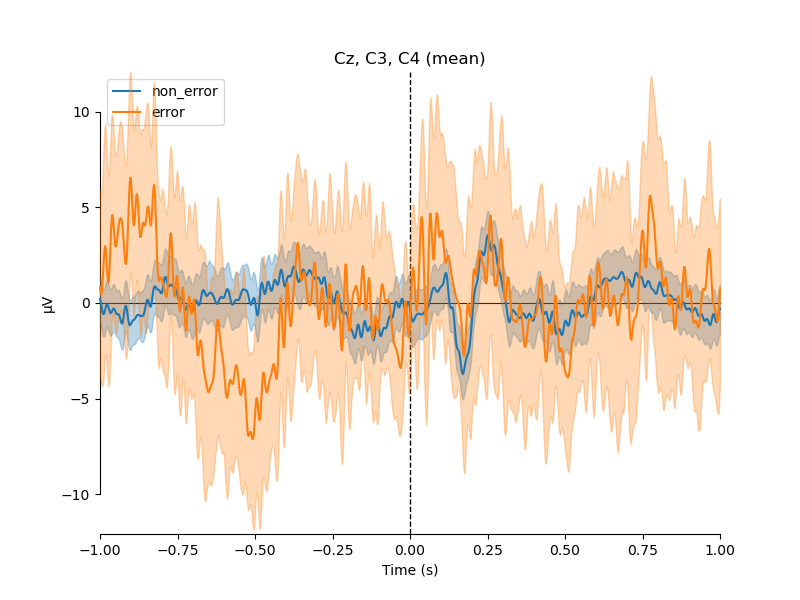

combining channels using "mean"
combining channels using "mean"


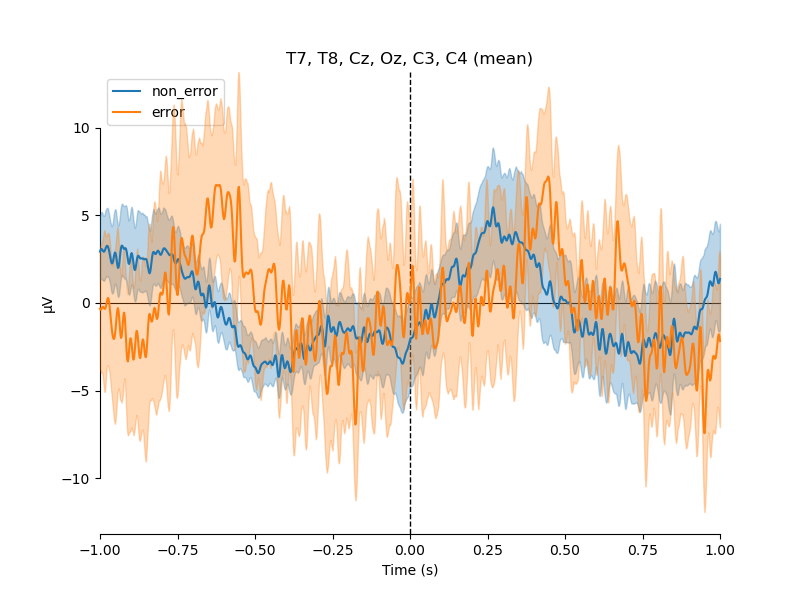

In [44]:
auditory_chans = ['T7', 'T8', 'Cz', 'Oz', 'C3', 'C4'] # 'Pz', 'Fz', 

for ep in eps:
    
    evokeds = dict(
        #cue=list(epochs['cue'].iter_evoked()),
        non_error=list(ep['non_error'].iter_evoked()),
        error=list(ep['error'].iter_evoked()),
    )
    
    fig = mne.viz.plot_compare_evokeds(
        evokeds, 
        picks = auditory_chans,
        combine='mean')

# Run DSS

In [ ]:
# Conduct DSS
# Compute original and biased covariance matrices
c0, _ = tscov(eeg_data_rs)
plt.imshow(c0, cmap=None, interpolation=None)
plt.colorbar()
plt.title("Covariance Matrix - EEG data")
plt.show()

# In this case the biased covariance is simply the covariance of the mean over
# trials
c1, _ = tscov(DSS_stream)
plt.imshow(c1, cmap=None, interpolation=None)
plt.colorbar()
plt.title("Covariance Matrix - Noise channel")
plt.show()

# Apply DSS
todss, _, pwr0, pwr1 = dss.dss0(c0, c1)

# plot components explaining variance
plt.figure(30)
plt.clf()
plt.plot(pwr1 / pwr0, '.-')
plt.title('repeatability')
plt.xlabel('component')
plt.ylabel('score')
plt.show()

# which composants to keep?
TOKEEP = [2,3,4,5]

z = fold(np.dot(unfold(eeg_data_rs), todss[:,TOKEEP]), epoch_size=eeg_data_rs.shape[0])
fromdss = np.linalg.pinv(todss)
# Find best components --> remove the noise
denoised_data = fold(np.dot(unfold(z), fromdss[TOKEEP,:]), epoch_size=eeg_data_rs.shape[0])

# Run ICA

In [45]:
from mne.preprocessing import ICA

icas = []

# Run ICA
for raw_pp in raws_preproc:
    
    # Make an ICA object
    ica = ICA(
        #n_components = 29, # number of prinicipal components passed to ICA
        random_state = 23, # seed for numpy RNG
        #method = 'infomax', # can use 'fastica' or 'picard' too
    )

    ica.fit(raw_pp)
    
    icas.append(ica)

Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 30 components
Fitting ICA took 10.8s.
Fitting ICA to data using 20 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 20 components
Fitting ICA took 5.3s.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 30 components
Fitting ICA took 17.1s.


Not setting metadata
506 matching events found
No baseline correction applied
0 projection items activated


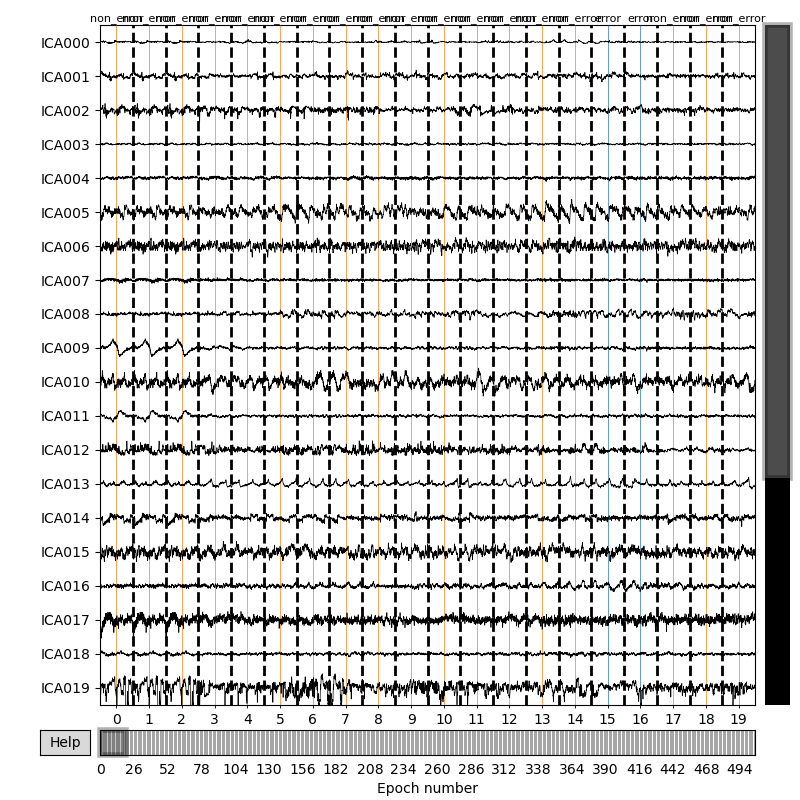

Not setting metadata
506 matching events found
No baseline correction applied
0 projection items activated


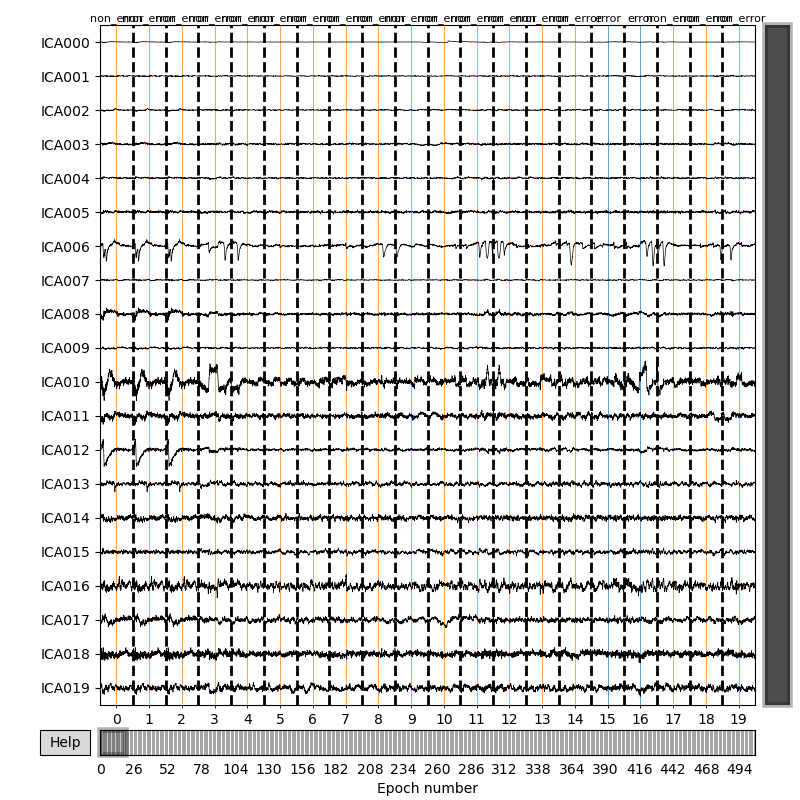

Not setting metadata
506 matching events found
No baseline correction applied
0 projection items activated


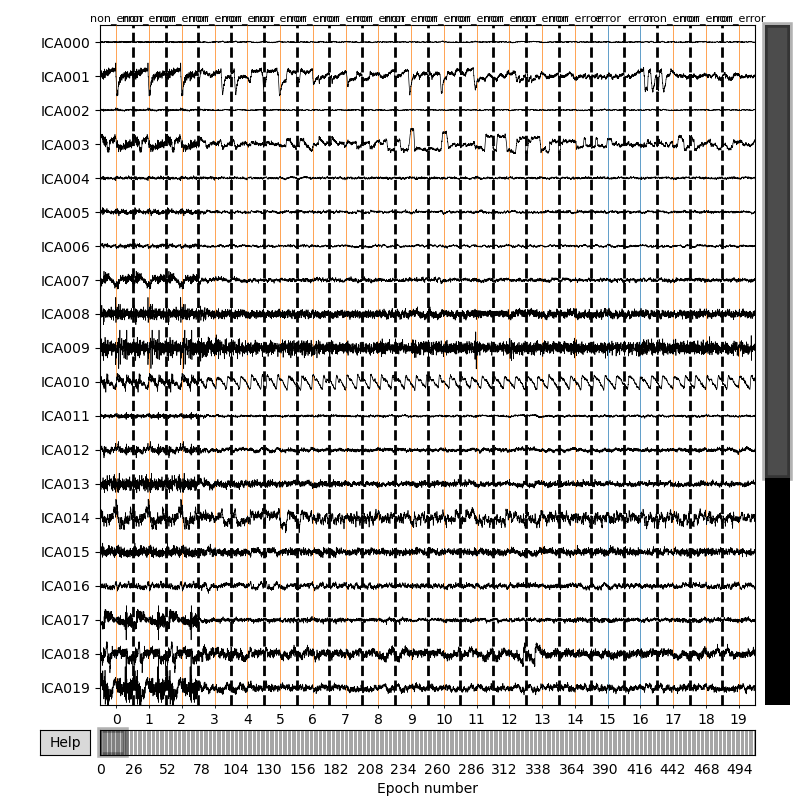

In [46]:
for i, ica in enumerate(icas):
    ica.plot_sources(
        eps[i],
        #start = PLOT_WINDOW_START_s,
        #stop = PLOT_WINDOW_START_s + PLOT_WINDOW_DUR_s,
    )

In [ ]:
suspect_ica_components = []

# First subject
suspect_ica_components.append(
    [
        1, # eye movemet
        8, # pulse
    ]
)

# Second subject
suspect_ica_components.append(
    [
        0, # eye blinks
    ]
)

# Third subject
suspect_ica_components.append(
    [
        1, # eye blinks
        10, # pulse
    ]
)

for i, ica in enumerate(icas):
    print('='*100)
    ica.plot_properties(
        eps[i],
        picks = suspect_ica_components[i], # select ICA components to plot topomaps for
    )

## Remove suspect ICA components

In [ ]:
for i, ica in enumerate(icas):
    eps[i] = ica.apply(
        eps[i], 
        exclude=suspect_ica_components[i], # ICA components to drop
    )

Plot ERPs again:

In [ ]:
for ev_id in erp_events[:2]:
    print('='*100)
    print(ev_id)
    
    for ep in eps:
        ep[ev_id].average(
            # picks = []
        ).plot_joint()

In [ ]:
%matplotlib inline

for eid in erp_events:
    print('='*100)
    print(eid)
    for ep in eps:
        ep[eid].plot_image(
            # picks = ['Cz', 'T7', 'T8', 'C3', 'C4', 'CP5', 'CP6'],
            combine='mean'
        )

In [ ]:
%matplotlib widget

# Identify and drop bad channels
raws_preproc[0].info.bads = ['F3', 'C4', 'CP5']
raws_preproc[1].info.bads = ['F4', 'F7', 'F8', 'Pz', 'P3', 'P4', 'P8', 'O2', 'O1', 'Fp1', 'Fp2']

for i in range(len(raws_preproc)):
    for ch in raws_preproc[i].info.bads:
        try:
            raws_preproc[i] = raws_preproc[i].drop_channels(ch)
        except ValueError as e:
            print(e)
            
# Make the epochs
'''
reject_criteria = dict(
    eeg=100e-6,  # 100 µV
)
'''
eps = []
for raw_pp in raws_preproc:
    ep = mne.Epochs(
        raw_pp,
        events = events, 
        event_id = event_ids, 
        tmin=-0.5,
        tmax=1,
        baseline=None,
        event_repeated = 'drop',
        # reject=reject_criteria,
        preload = True,
    )
    eps.append(ep)

for ev_id in erp_events[:2]:
    print('='*100)
    print(ev_id)
    
    for ep in eps:
        ep[ev_id].average(
            # picks = []
        ).plot_joint()

# Manually reject bad data segments
(skip for now)

In [ ]:
if 0: 
    bad_annot = mne.Annotations(
        onset = [7, 11, ],
        duration = [3, 19, ], # setting durations to 0 to just label event onsets
        description = "bad",
    )

    #raw.set_annotations(raw.annotations + bad_annot)
    raw.set_annotations(lsl_annot + bad_annot)
    
    # Plot again
    raw.plot(
        scalings = scalings,
        butterfly = True,
        start = PLOT_WINDOW_START_s,
        duration = PLOT_WINDOW_DUR_s,
    )

In [ ]:
# Remove any erroneous annotations (if needed)
# raw.annotations[5]
# raw.annotations.delete(5)

# Power Spectra
(before filtering)

In [ ]:
for raw in raws:
    raw.compute_psd(n_fft = 1024).plot(average = False)

# Identify any bad channels
(skip for now)

In [ ]:
## Update scalings if needed
scalings['eeg'] = 200e-6 
# scalings['eog'] = 500e-6
# scalings['misc'] = 100

for raw_pp in raws_preproc:
    raw_pp.info.bads = [] #'Oz', 'PO8', 'Fp2', 'F7', 'P3'] # ideally could label bad segments instead of dropping channels

    # Drop bad channels from visual examination before running ICA
    raw_pp = raw_pp.drop_channels(raw_pp.info.bads)

    raw_pp.plot(
        scalings = scalings,
        butterfly = True,
        start = PLOT_WINDOW_START_s,
        duration = PLOT_WINDOW_DUR_s,
)

## Re-reference to average? Skip for now.
https://mne.tools/stable/generated/mne.set_eeg_reference.html

Re-referencing to average seems to just output noise...

In [ ]:
if 0:
    for raw_pp in raws_preproc:

        raw_pp, _ = mne.set_eeg_reference(
            raw_pp, 
            ref_channels=['A2'], # 'average'
        )

        raw_pp.plot(
            scalings=scalings,
            butterfly=True,
            start = PLOT_WINDOW_START_s,
            duration = PLOT_WINDOW_DUR_s,
        )

# Export dataset to EEGLAB

In [ ]:
# uncomment to install eeglabio
# !pip3 install eeglabio

In [ ]:
MAT_PATH = DATA_PATH.split('.xdf')[0] + f'_bpf_{l_freq}-{h_freq}Hz' + '.mat'
MAT_PATH

In [ ]:
# This is a .set file that can be loaded directly into MATLAB (using load)
## Note that this would include any 'bad' channels identified above

try:
    mne.export.export_raw(
        MAT_PATH, 
        raw_filt_drop_bad_rref, 
        fmt='eeglab')
except FileExistsError as e:
    print(e)

# if exporting to EDF:
# Note that the BrainVision format specification supports only µV.
#raw_filt_drop_bad = raw_filt.copy().drop_channels(raw_filt.info['bads'])
#mne.export.export_raw('head_bob-raw_filt-drop_bad_chan.edf', raw_filt_drop_bad, fmt='edf')

# Import ASR'd data

In [ ]:
from scipy.io import loadmat

In [ ]:
after_asr = loadmat('/Volumes/GoogleDrive/.shortcut-targets-by-id/1mvHxk9Ra9K7MmjQxaRYiZKwUw4Y8o841/AC23/DATA/active_piano/sub-matthias/ses-S001/diverse/after_asr.mat')

In [ ]:
clean_data = after_asr['clean_data']
n_chans, n_samples = clean_data.shape

In [ ]:
clean_data

In [ ]:
t_clean_data = after_asr['t_clean_data'][0]
t_clean_data.shape

In [ ]:
n_clean_data = np.int64(t_clean_data * 500)
n_clean_data

In [ ]:
clean_data_full = np.zeros(
    shape=(n_chans, n_clean_data[-1])
)
clean_data_full.shape

In [ ]:
clean_data_full[0, n_clean_data-1]

In [ ]:
clean_data[0].shape

In [ ]:
for ch in range(n_chans):
    clean_data_full[ch][n_clean_data -1] = clean_data[ch]
    
clean_data_full

In [ ]:
clean_ch_names = eeg_ch_names[:16] + eeg_ch_names[16:n_chans]
len(clean_ch_names)

In [ ]:
info = mne.create_info(
    ch_names = clean_ch_names,
    sfreq = 500,
    ch_types = ['eeg'] * n_chans,
)

In [ ]:
raw_asr = mne.io.RawArray(
    clean_data_full / 1e6,
    info = info,
)
raw_asr

In [ ]:
raw_asr[0]

In [ ]:
raw_asr.info.set_montage('standard_1020', match_case=False)

In [ ]:
%matplotlib widget

raw_asr.plot()

In [ ]:
eps_asr = mne.Epochs(
    raw_asr,
    events = events, 
    event_id = event_id, 
    tmin=-0.5,
    tmax=1.5,
    baseline=None,
    event_repeated = 'drop',
)

In [ ]:
for ev_id in erp_event_id:
    print(ev_id)
    
    eps_asr[ev_id].average(
        #picks = ['Cz']
    ).plot_joint(
        #times = [-1.78, -1.38, 0.352, 0.65] #"peaks"
    )

In [ ]:
%matplotlib inline

for ev_id in erp_event_id:
    print(ev_id)
    eps_asr[ev_id].plot_image(
        #picks = [],
        combine='mean'
    )